## Hamiltonian Monte Carlo in the TrueSkill Model

In [12]:
import os
import os.path
import matplotlib.pyplot as plt
import wget
import pandas as pd
import numpy as np
from scipy.stats import norm
import scipy.io
import scipy.stats
import torch
import random
from torch.distributions.normal import Normal
from functools import partial
import matplotlib.pyplot as plt

We’ll implement a variant of the TrueSkill model, a player ranking system for competitive games
originally developed for Halo 2. It is a generalization of the Elo rating system in Chess. 
We’ll consider a slightly simplified version of the original trueskill model. We assume that each
player has a true, but unknown skill $𝑧_𝑖 \in \mathbb{R}$. We use $𝑁$ to denote the number of players


## Model definition
We'll consider a slightly simplified version of the original trueskill model.
We assume that each player has a true, but unknown skill $z_i \in \mathbb{R}$.
We use $N$ to denote the number of players.

### The prior:
The prior over each player's skill is a standard normal distribution, and all player's skills are *a priori* independent.

### The likelihood:
For each observed game, the probability that player $i$ beats player $j$, given the player's skills $z_A$ and $z_B$, is:
$$p(A \,\, \text{beat} \,\, B | z_A, z_B) = \sigma(z_A - z_B)$$
where
$$\sigma(y) = \frac{1}{1 + \exp(-y)}$$
We chose this function simply because it's close to zero or one when the player's skills are very different, and equals one-half when the player skills are the same.  This likelihood function is the only thing that gives meaning to the latent skill variables $z_1 \dots z_N$.

There can be more than one game played between a pair of players. The outcome of each game is independent given the players' skills.
We use $M$ to denote the number of games.



## Implementing the TrueSkill Model

First, we will implement a function log_joint_prior that computes the log of the prior distribution for a given set of player skills. Specifically, given a  K×N  array where each row is a setting of the skills for all  N  players, it returns a  K×1  array, where each row contains a scalar giving the log-prior for that set of skills.

In [14]:
def log_joint_prior(zs_array):

    m = Normal(0., 1.)
    return m.log_prob(zs_array).sum(axis=-1)


We will implement two functions, logp_a_beats_b and logp_b_beats_a, to evaluate the log-likelihood of one player beating another based on their skills.

In [15]:
def logp_a_beats_b(z_a, z_b):

    return -torch.logaddexp(torch.tensor([0.0]), z_b - z_a)
def logp_b_beats_a(z_a, z_b):

    return -torch.logaddexp(torch.tensor([0.0]), z_a - z_b)

To get a feel for this model, we’ll first consider the case where we only have 2 players, 𝐴 and 𝐵.
We’ll examine how the prior and likelihood interact when conditioning on different sets of games.
Function plot_isocontours which evaluates a provided function
on a grid of 𝑧𝐴 and 𝑧𝐵’s and plots the isocontours of that function.

In [18]:
# Plotting helper functions
def plot_isocontours(ax, func, steps=100):
    x = torch.linspace(-4, 4, steps=steps)
    y = torch.linspace(-4, 4, steps=steps)
    X, Y = torch.meshgrid(x, y)
    Z = func(X, Y)
    cs = plt.contour(X, Y, Z )
    plt.clabel(cs, inline=1, fontsize=10)
    ax.set_yticks([])
    ax.set_xticks([])

def plot_2d_fun(f, x_axis_label="", y_axis_label="", scatter_pts=None):
    fig = plt.figure(figsize=(8,8), facecolor='white')
    ax = fig.add_subplot(111, frameon=False)
    ax.set_xlabel(x_axis_label)
    ax.set_ylabel(y_axis_label)
    plot_isocontours(ax, f)
    if scatter_pts is not None:
        plt.scatter(scatter_pts[:,0], scatter_pts[:, 1])
    plt.plot([4, -4], [4, -4], 'b--')   # Line of equal skill
    plt.show(block=True)
    plt.draw()

To visualize the joint prior over the skills of two players, along with the line of equal skill ($z_A = z_B$), we'll use the plot_2d_fun helper function.


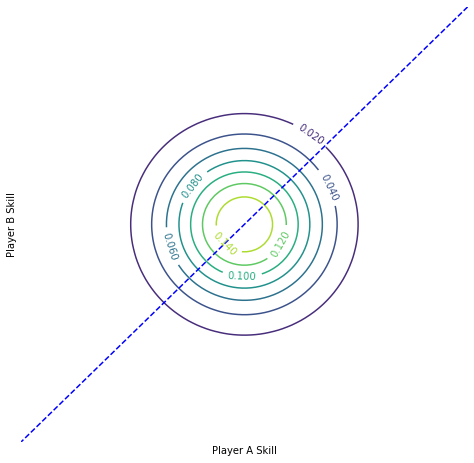

<Figure size 432x288 with 0 Axes>

In [20]:
def log_prior_over_2_players(z1, z2):
    m = Normal(0., 1.)
    return m.log_prob(z1) + m.log_prob(z2)
def prior_over_2_players(z1, z2):
    return torch.exp(log_prior_over_2_players(z1, z2))

plot_2d_fun(prior_over_2_players, "Player A Skill", "Player B Skill");

To visualize the joint posterior over the skills of two players after player A beats player B, along with the line of equal skill ($z_A = z_B$), we'll plot the isocontours of the log of the joint distribution.

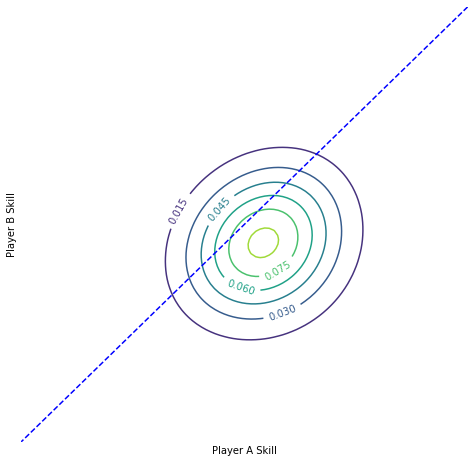

<Figure size 432x288 with 0 Axes>

In [21]:
def log_posterior_A_beat_B(z1, z2):
    return log_prior_over_2_players(z1, z2) + logp_a_beats_b(z1, z2)

def posterior_A_beat_B(z1, z2):
    return torch.exp(log_posterior_A_beat_B(z1, z2))
plot_2d_fun(posterior_A_beat_B, "Player A Skill", "Player B Skill")
# Note that the posterior probabilities shown are unnormalized

Now, we can visualize the joint posterior over the skills of two players after 5 matches where player A beat player B in all matches, along with the line of equal skill ($z_A = z_B$).

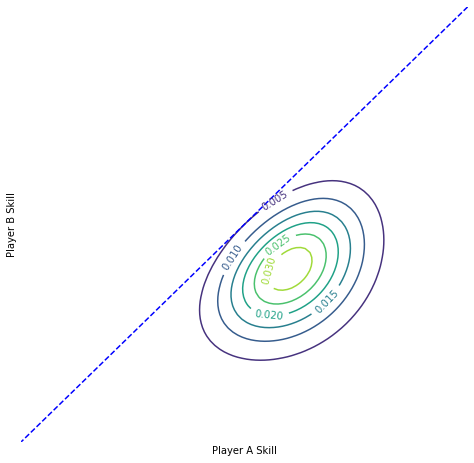

<Figure size 432x288 with 0 Axes>

In [22]:
def log_posterior_A_beat_B_5_times(z1, z2):
    return (log_prior_over_2_players(z1, z2) + 5.0 * logp_a_beats_b(z1, z2))

def posterior_A_beat_B_5_times(z1, z2):
    return torch.exp(log_posterior_A_beat_B_5_times(z1, z2))

plot_2d_fun(posterior_A_beat_B_5_times, "Player A Skill", "Player B Skill")

We can also see what it looks like when after 10 matches where each player beat the other 5 times, along with the line of equal skill ($z_A = z_B$), we'll plot the isocontours of the log of the joint distribution.

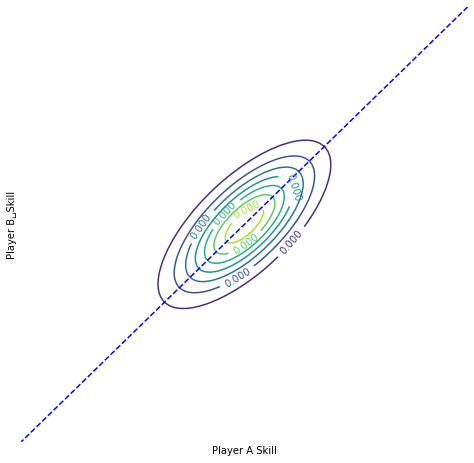

<Figure size 432x288 with 0 Axes>

In [23]:
def log_posterior_beat_each_other_5_times(z1, z2):
    return log_prior_over_2_players(z1, z2) + 5.* logp_a_beats_b(z1, z2) + 5.* logp_b_beats_a(z1, z2)
def posterior_beat_each_other_5_times(z1, z2):
    return torch.exp(log_posterior_beat_each_other_5_times(z1, z2))

plot_2d_fun(posterior_beat_each_other_5_times, "Player A Skill", "Player B␣Skill")

## Hamiltonian Monte Carlo on Two Players and Toy Data

Bayesian approach separates the model specification from the approximate inference strategy. The original Trueskill paper from 2007 used message passing.
For now, we will approximate posterior distributions with gradient-based Hamiltonian Monte Carlo.

In [24]:
random.seed(42)
torch.manual_seed(42)

from tqdm import trange, tqdm_notebook 

# Hamiltonian Monte Carlo
from tqdm import trange, tqdm_notebook  # Progress meters

def leapfrog(params_t0, momentum_t0, stepsize, logprob_grad_fun):
  # Performs a reversible update of parameters and momentum
  # See https://en.wikipedia.org/wiki/Leapfrog_integration
    momentum_thalf = momentum_t0    + 0.5 * stepsize * logprob_grad_fun(params_t0)
    params_t1 =      params_t0      +       stepsize * momentum_thalf
    momentum_t1 =    momentum_thalf + 0.5 * stepsize * logprob_grad_fun(params_t1)
    return params_t1, momentum_t1


def iterate_leapfrogs(theta, v, stepsize, num_leapfrog_steps, grad_fun):
    for i in range(0, num_leapfrog_steps):
        theta, v = leapfrog(theta, v, stepsize, grad_fun)
    return theta, v

def metropolis_hastings(state1, state2, log_posterior):
  # Compares the log_posterior at two values of parameters,
  # and accepts the new values proportional to the ratio of the posterior
  # probabilities.
    accept_prob = torch.exp(log_posterior(state2) - log_posterior(state1))
    if random.random() < accept_prob:
        return state2  # Accept
    else:
        return state1  # Reject

def draw_samples(num_params, stepsize, num_leapfrog_steps, n_samples, log_posterior):
    theta = torch.zeros(num_params)

    def log_joint_density_over_params_and_momentum(state):
        params, momentum = state
        m = Normal(0., 1.)
        return m.log_prob(momentum).sum(axis=-1) + log_posterior(params)

    def grad_fun(zs):
        zs = zs.detach().clone()
        zs.requires_grad_(True)
        y = log_posterior(zs)
        y.backward()
        return zs.grad



    sampleslist = []
    for i in trange(0, n_samples):
        sampleslist.append(theta)

        momentum = torch.normal(0, 1, size = np.shape(theta))

        theta_new, momentum_new = iterate_leapfrogs(theta, momentum, stepsize, num_leapfrog_steps, grad_fun)

        theta, momentum = metropolis_hastings((theta, momentum), (theta_new, momentum_new), log_joint_density_over_params_and_momentum)
    return torch.stack((sampleslist))

Using samples generated by HMC, we cab approximate the joint posterior where we observe player A winning 1 game.

100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:55<00:00, 45.27it/s]


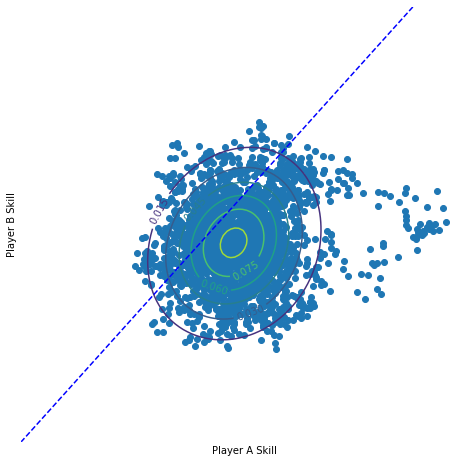

<Figure size 432x288 with 0 Axes>

In [26]:
# Hyperparameters
num_players = 2
num_leapfrog_steps = 20
n_samples = 2500
stepsize = 0.01

def log_posterior_a(zs):
    z1, z2 = zs[0], zs[1]
    return log_posterior_A_beat_B(z1, z2)

samples_a = draw_samples(num_players, stepsize, num_leapfrog_steps, n_samples, log_posterior_a)
plot_2d_fun(posterior_A_beat_B, "Player A Skill", "Player B Skill", samples_a)

Using samples generated by HMC, we can approximate the joint posterior where we observe player A winning 5 games against player B.

100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:51<00:00, 48.12it/s]


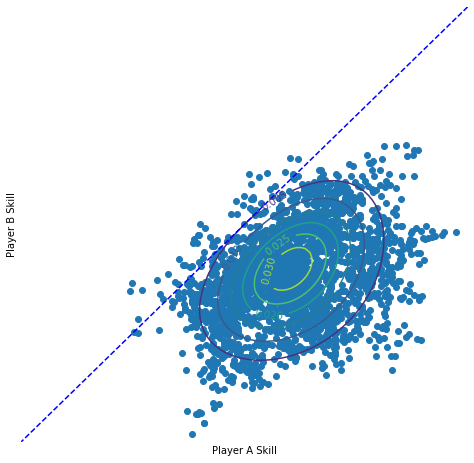

<Figure size 432x288 with 0 Axes>

In [27]:
def log_posterior_b(zs):
    z1, z2 = zs[0], zs[1]
    return log_posterior_A_beat_B_5_times(z1, z2)

samples_b = draw_samples(num_players, stepsize, num_leapfrog_steps, n_samples, log_posterior_b)
plot_2d_fun(posterior_A_beat_B_5_times, "Player A Skill", "Player B Skill", samples_b)

Or approximate the joint posterior where we observe player A winning 5 games and player B winning 5 games.

100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [01:08<00:00, 36.41it/s]


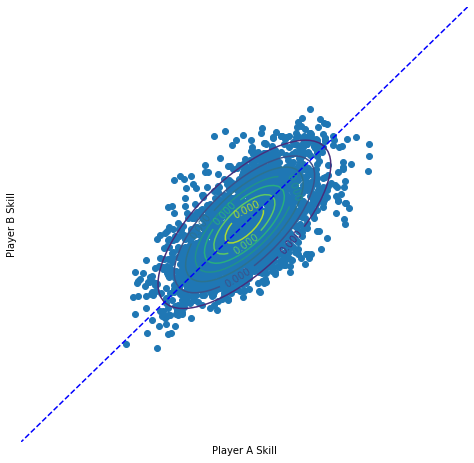

<Figure size 432x288 with 0 Axes>

In [28]:
def log_posterior_c(zs):
    z1, z2 = zs[0], zs[1]
    return log_posterior_beat_each_other_5_times(z1,z2)

samples_c = draw_samples(num_players, stepsize, num_leapfrog_steps, n_samples, log_posterior_c)
plot_2d_fun(posterior_beat_each_other_5_times, "Player A Skill", "Player B Skill", samples_c)

## Inference conditioned on Real data 

The dataset contains data on 2546 chess games amongst 1434 players:
 - names is a 1163 by 1 matrix, whose $i$’th entry is the name of player $i$.
 - games is a 2543 by 2 matrix of game outcomes (actually chess matches), one row per game.

The first column contains the indices of the players who won.
The second column contains the indices of the player who lost.

It is based on the kaggle chess dataset: https://www.kaggle.com/datasets/datasnaek/chess


In [29]:
wget.download("https://vahidbalazadeh.me/assets/datasets/chess_players.csv")
wget.download("https://vahidbalazadeh.me/assets/datasets/chess_games.csv")
games = pd.read_csv("chess_games.csv")[["winner_id", "loser_id"]].to_numpy()
names = pd.read_csv("chess_players.csv")[["player_name"]].to_numpy().astype('str')

games = torch.LongTensor(games)

100% [..............................................................................] 20722 / 20722

Assuming all game outcomes are i.i.d. conditioned on all players' skills, we can implement a function $\texttt{log_games_likelihood}$ that takes a batch of player skills $\texttt{zs}$ and a collection of observed games $\texttt{games}$ and gives the total log-likelihoods for all those observations given all the skills. In addition we will implement a function $\texttt{joint_log_density}$ which combines the log-prior and log-likelihood of the observations to give $p(z_1, z_2, \dots, z_N, \text{all game outcomes})$

In [32]:
def log_games_likelihood(zs, games):

    winning_player_ixs = games[:,0]
    losing_player_ixs = games[:,1]
    winning_player_skills = zs[winning_player_ixs]
    losing_player_skills = zs[losing_player_ixs]
    log_likelihoods = logp_a_beats_b(winning_player_skills, losing_player_skills)
    return log_likelihoods.sum()

def log_joint_probability(zs, games):

    return log_joint_prior(zs) + log_games_likelihood(zs, games)


Now, we will run Hamiltonian Monte Carlo on the posterior over all skills conditioned on all the chess games from the dataset.

In [33]:
# Hyperparameters
num_players = 1163
num_leapfrog_steps = 20
n_samples = 10000
stepsize = 0.01

def log_posterior(zs):
    return log_joint_probability(zs, games)

all_games_samples = draw_samples(num_players, stepsize, num_leapfrog_steps, n_samples, log_posterior)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [04:38<00:00, 35.90it/s]


We canplot the approximate mean and variance of the marginal skill of each player, sorted by average skill.

<ErrorbarContainer object of 3 artists>

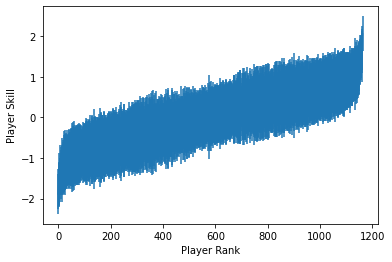

In [34]:
mean_skills = torch.mean(all_games_samples, dim=0)
var_skills = torch.var(all_games_samples, dim=0)

ordered = np.argsort(mean_skills)

plt.xlabel("Player Rank")
plt.ylabel("Player Skill")
plt.errorbar(range(num_players), mean_skills[ordered], var_skills[ordered])

Let's check the names of the 5 players with the lowest mean skill and 5 players with the highest mean skill according to our samples.

In [35]:
print("Bottom 5")

for i in ordered[:5]:
    print(names[i][0])


print("Top 5")

for i in ordered[-5:]:
    print(names[i][0])


Bottom 5
josephelbouhessaini
vkmansftw
italiantranslator
thebestofthebad
kylarr
Top 5
projetoxadrez
chesswithmom
smartduckduckcow
mrzoom47
doraemon61


Let's choose 2 players from the dataset and use a scatterplot to show samples over the joint posterior over their skill.

Text(0, 0.5, 'Skill of thebestofthebad')

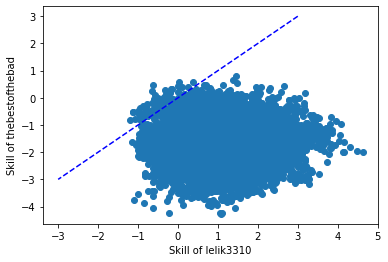

In [36]:
lelik3310_ind  = np.where(names == 'lelik3310')[0][0]
thebestofthebad_ind = np.where(names == 'thebestofthebad')[0][0]

plt.scatter(all_games_samples[:, lelik3310_ind], all_games_samples[:, thebestofthebad_ind])
plt.plot([3, -3], [3, -3], 'b--')
plt.xlabel('Skill of lelik3310')
plt.ylabel('Skill of thebestofthebad')

We can also compute an unbiased estimate of the probability that some player is not worse than another. For example, we can compute unbiased estimate of the probability that the player with the eleventh highest mean skill is not worse than "bassboy", as estimated from our samples. Note that probabilities of Bernoulli random variables can be written as the expectation that the Bernoulli takes value 1, so we can use simple Monte Carlo.

In [40]:
name_11 = ordered[-11]

print("Eleventh mean skill player: ", names[name_11][0])

ind = np.where(names == 'bassboy')[0][0]

samples_12 = all_games_samples[:, ordered[-12]]
bassboy = all_games_samples[:, ind]

samp_prob = sum([bassboy[i] < samples_12[i] for i in range(len(bassboy))]) / len(bassboy)

print("Probability that the player with the twelfth highest highest mean skill is not worse than bassboy: ", float(samp_prob))

Eleventh mean skill player:  vitaminex
Probability that the player with the twelfth highest highest mean skill is not worse than bassboy:  0.6796000003814697
